<a href="https://colab.research.google.com/github/revanks/Xeeva_Task_Files/blob/main/Task_1_LSTM_Multiclass_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Task - 1.	Text classification using LSTM  </center>

## Importing libraries and data

In [1]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from google.colab import files
data=files.upload()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving bert_sample.xlsx to bert_sample.xlsx


In [2]:
df=pd.read_excel('bert_sample.xlsx')
df1=pd.DataFrame(df)
df1.head()

,ITEM_NAME,CATEGORY_ID
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY
1,for pusher whskey,CAPITAL ASSEMBLY
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY


In [3]:
!pip install np_utils

     |████████████████████████████████| 61 kB 3.6 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=788c36a438ef4501b72afd9714ee29e65d15a664cf80ff0d8a28a1be28bf63b0
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils


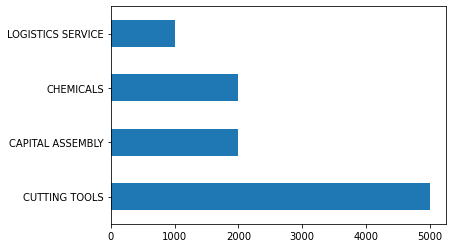

In [5]:
df1['CATEGORY_ID'].value_counts().plot(kind="barh");

## Data Preprocessing

In [6]:
#data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df1['ITEM_NAME'] = df1['ITEM_NAME'].apply(clean_text)



In [7]:
df1

,ITEM_NAME,CATEGORY_ID
0,calibracion transducer 75 nm,CAPITAL ASSEMBLY
1,pusher whskey,CAPITAL ASSEMBLY
2,stat 40b press head cup carrier stations k2 t1...,CAPITAL ASSEMBLY
3,transd cable 4145097103 scrw,CAPITAL ASSEMBLY
4,zt200 7 5bar 13bar60hz numero de serie aif0944...,CAPITAL ASSEMBLY
...,...,...
9995,eport freight charges road,LOGISTICS SERVICE
9996,eport packing,LOGISTICS SERVICE
9997,epress delivery charges,LOGISTICS SERVICE
9998,epress delivery charges pmf chmf despatch tata...,LOGISTICS SERVICE


In [8]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['ITEM_NAME'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17351 unique tokens.


In [9]:
X = tokenizer.texts_to_sequences(df1['ITEM_NAME'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [10]:
Y = pd.get_dummies(df1['CATEGORY_ID']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 4)


In [11]:
Y = pd.get_dummies(df1['CATEGORY_ID'])
Y

,CAPITAL ASSEMBLY,CHEMICALS,CUTTING TOOLS,LOGISTICS SERVICE
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
9995,0,0,0,1
9996,0,0,0,1
9997,0,0,0,1
9998,0,0,0,1


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9000, 250) (9000, 4)
(1000, 250) (1000, 4)


##LSTM Model Buliding

In [13]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
127/127 [==============================] - 99s 753ms/step - loss: 0.9718 - accuracy: 0.5962 - val_loss: 0.5765 - val_accuracy: 0.7978
Epoch 2/5
127/127 [==============================] - 95s 748ms/step - loss: 0.4191 - accuracy: 0.8559 - val_loss: 0.3478 - val_accuracy: 0.8889
Epoch 3/5
127/127 [==============================] - 95s 748ms/step - loss: 0.1919 - accuracy: 0.9415 - val_loss: 0.3048 - val_accuracy: 0.9056
Epoch 4/5
127/127 [==============================] - 95s 748ms/step - loss: 0.0973 - accuracy: 0.9733 - val_loss: 0.3004 - val_accuracy: 0.9044
Epoch 5/5
127/127 [==============================] - 96s 754ms/step - loss: 0.0490 - accuracy: 0.9869 - val_loss: 0.3329 - val_accuracy: 0.9056


## Evaluating Model Performance

In [15]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1])) 

32/32 [==============================] - 2s 68ms/step - loss: 0.5464 - accuracy: 0.8470
Test set
  Loss: 0.546
  Accuracy: 0.847


In [27]:
X_test

array([[    0,     0,     0, ...,    22,     4,  1404],
       [    0,     0,     0, ...,  1377,   777,   390],
       [    0,     0,     0, ...,  3347,  8985,   906],
       ...,
       [    0,     0,     0, ...,     1,  1200,  1709],
       [    0,     0,     0, ...,     7,   510,  3252],
       [    0,     0,     0, ..., 15036,   936, 15037]], dtype=int32)

In [32]:
import numpy as np
#array=np.array(Y_test[['CAPITAL ASSEMBLY', 'CHEMICALS',	'CUTTING TOOLS','LOGISTICS SERVICE']])
array=np.array(Y_test)
y_test_true=np.argmax(array, axis=1)
len(array)


1000

In [40]:
y_test_pred=model.predict(X_test)
y_test_pred=np.argmax(y_test_pred, axis=1)

In [41]:
from sklearn.metrics import classification_report
LABEL_COLUMNS=['CAPITAL ASSEMBLY', 'CHEMICALS',	'CUTTING TOOLS','LOGISTICS SERVICE']
print(classification_report(y_test_true,y_test_pred, target_names=LABEL_COLUMNS))

                   precision    recall  f1-score   support

 CAPITAL ASSEMBLY       0.85      0.76      0.80       211
        CHEMICALS       0.70      0.83      0.76       177
    CUTTING TOOLS       0.91      0.91      0.91       527
LOGISTICS SERVICE       0.80      0.72      0.76        85

         accuracy                           0.85      1000
        macro avg       0.82      0.80      0.81      1000
     weighted avg       0.85      0.85      0.85      1000



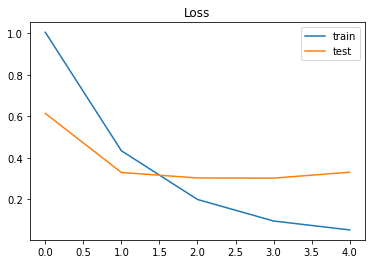

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

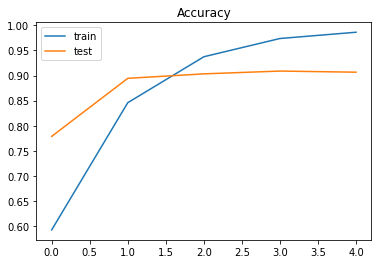

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
new_complaint = ['Express Delivery Charges with Dubble Driver']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['CAPITAL ASSEMBLY',	'CHEMICALS',	'CUTTING TOOLS',	'LOGISTICS SERVICE']
print(pred, labels[np.argmax(pred)])

[[5.4773584e-04 2.1621061e-03 1.5300004e-05 9.9727482e-01]] LOGISTICS SERVICE
